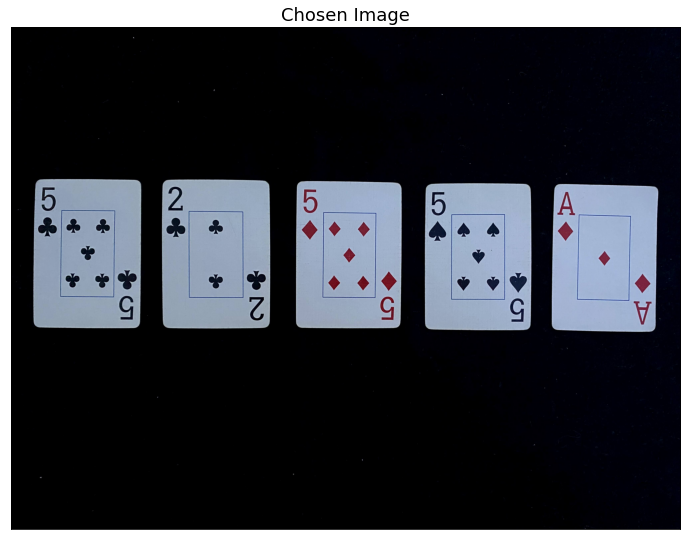


The card is a: Black 2 of Clubs


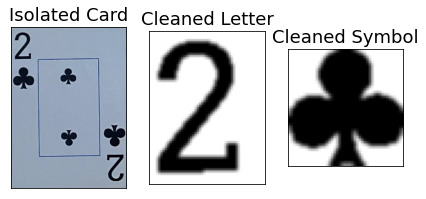


The card is a: Black 5 of Clubs


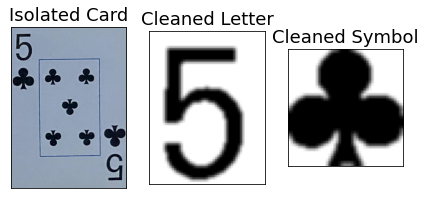


The card is a: Black 5 of Spades


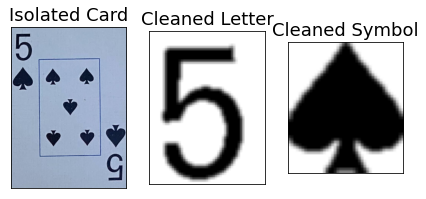


The card is a: Red 5 of Diamonds


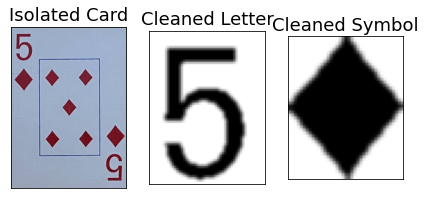


The card is a: Red Ace of Diamonds


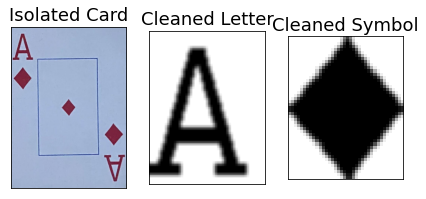



The hand you have is: 3 of a kind




In [1]:
#Poker card game assistant that returns the type of hand the player has from an input image
#By Kyle Heffernan, Eoin Gallagher and Ryan Byrne 26/11/20

#Imports
import cv2
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import image as image
import easygui
import pytesseract

#Set plot parameters
plt.rcParams['figure.figsize'] = [12,16]#set the plot size
plt.rc('font', size=15)

#Perform all operations and methods on input image and print hand at the end
def readCards(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    G = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    #Show full input image at start
    plt.imshow(img, cmap='gray'), plt.xticks([]),plt.yticks([])
    plt.title('Chosen Image')
    plt.show()
    
    #Find cards by making a mask with thresholding and getting the largest contours of that
    T, B = cv2.threshold(G, thresh = 120, maxval = 255, type = cv2.THRESH_BINARY)
    C,_ = cv2.findContours(B, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)
    C = sorted(C, key=cv2.contourArea, reverse=True)
    
    # Reading in suit templates, done here so its only ran once and helps performance
    club = cv2.imread("SymbolComparisons\club.jpg")
    diamond = cv2.imread("SymbolComparisons\diamond.jpg")
    heart = cv2.imread("SymbolComparisons\heart.jpg")
    spade = cv2.imread("SymbolComparisons\spade.jpg")
    
    #Make arrays of letters and symbols to be passed to the GetHandType method
    cardLetters = [""]*5
    cardSymbols = [""]*5
    
    #Performs operations on the 5 biggest contours
    i = 0
    while i < 5:
        fig = plt.figure()#make a figure to show things on

        largestContour = C[i]
        warpedImg = warpPerspective(largestContour)

        #Crop image to just the card
        H,W,Channels = warpedImg.shape

        #Get the area around the Letter and symbol to pass them to their detection functions
        cropped_letter = warpedImg[int(H * 0.026):int(H * 0.22), int(W * 0.017):int(W * 0.22)]
        symbolArea = warpedImg[int(H * 0.18):int(H * 0.4), int(W * 0.015):int(W * 0.21)]
        #cv2.imshow("cropped_symbol", symbolArea)
        #key = cv2.waitKey(0)

        #Use cropped areas to call a function that return the text of what the symbol and letter are respectively
        cardSymbol = GetSymbol(symbolArea,fig,club,diamond,heart,spade)#Also pass fig to display
        cardLetter = GetLetter(cropped_letter,fig)
        
        if(cardSymbol == "Club" or cardSymbol == "Spade"):
            cardCol = "Black"
        else:
            cardCol = "Red"
        
        #Fill arrays for getHandType with each value of the card
        cardLetters[i] = cardLetter
        cardSymbols[i] = cardSymbol

        i = i + 1#increment through cards
        
        #Tell the user the info about each card
        print("\nThe card is a: "+cardCol+" "+cardLetter+" of "+cardSymbol+"s")
        #Display to notebook
        warpedImg = cv2.cvtColor(warpedImg, cv2.COLOR_BGR2RGB)#Change for displaying
        p1 = fig.add_subplot(2, 5, 1), plt.xticks([]),plt.yticks([])
        plt.title('Isolated Card')
        imgplot = plt.imshow(warpedImg, cmap='gray')
        plt.show()#Show 3 plots that have been made
        
    #Call method that uses all the card info to find what hand the user has and print it    
    GetHandType(cardLetters,cardSymbols)
        
#Use input image of the Letter in the top left to return the card type usign tesseract OCR. Also takes fig for plotting in notebook and it returns the cardType it finds
def GetLetter(croppedLetter,fig):
    #Convert, threshold and clean input image to be used by OCR
    gCroppedLetter = cv2.cvtColor(croppedLetter, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gCroppedLetter, 130, 255, cv2.THRESH_BINARY_INV)[1]
    imBlur = cv2.GaussianBlur(thresh, (3,3), 0)
    imBlur = 255 - imBlur#Invert

    #convert to text from the image with the letter using pytesseract
    textFromImage = pytesseract.image_to_string(imBlur, lang='eng',config='--psm 6')
    
    #Clean any extra characters or spaces it picked up so that its onyl one letter
    if(len(textFromImage) < 2):
        singleChar = textFromImage
    else:
        singleChar = textFromImage[0]
        
        
    cardType = ""
    #Special cards have a name so return that, or some characters are too similiar depending on font so it recognises most likely characters
    if(singleChar == "K" or singleChar == "k"):
        cardType = "King"
    elif(singleChar == "Q"):
        cardType = "Queen"
    elif(singleChar == "J" or singleChar == "j"):
        cardType = "Jack"
    elif(singleChar == "A"):
        cardType = "Ace"
    elif(singleChar == "1" or singleChar == "0" or singleChar == "i" or singleChar == "l"):
        cardType = "10"
    elif(singleChar == "%"):
        cardType = "3"
    elif(singleChar == "h"):
        cardType = "5"
    else:#is number
        cardType = singleChar
           
    #Error checking for bad quality input
    if not(allPlayingCardTypes.__contains__(cardType)):
        print("Error detecting card, image may be of low quality")
        
    #Add to plot for displaying
    p1 = fig.add_subplot(2, 5, 2), plt.xticks([]),plt.yticks([])
    plt.title('Cleaned Letter')
    imgplot = plt.imshow(imBlur, cmap='gray')
    
    return cardType

def GetSymbol(symbolArea,fig,club,diamond,heart,spade):
    G = cv2.cvtColor(symbolArea, cv2.COLOR_BGR2GRAY)
    T, B = cv2.threshold(G, thresh = 120, maxval = 255, type = cv2.THRESH_BINARY)
    inverse = cv2.bitwise_not(B)
    sContour,_ = cv2.findContours(inverse, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)
    sC = sorted(sContour, key=cv2.contourArea, reverse=True)
    x,y,w,h = cv2.boundingRect(sC[0])
    cropped_symbol = symbolArea[y:y+h,x:x+w]

    G = cv2.cvtColor(cropped_symbol, cv2.COLOR_BGR2GRAY)
    T, B = cv2.threshold(G, thresh = 120, maxval = 255, type = cv2.THRESH_BINARY)
    inverse = cv2.bitwise_not(B)
    sContour,_ = cv2.findContours(inverse, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)
    sC = sorted(sContour, key=cv2.contourArea, reverse=True)

    cropped = cropped_symbol
    croppedH, croppedW, croppedChannels = cropped.shape 
    cropped_symbol = np.zeros([croppedH,croppedW,3],dtype=np.uint8)
    cropped_symbol.fill(255)
    cv2.fillPoly(cropped_symbol, pts =[(sC[0])], color=(0,0,0))
    cropped_symbol =  cv2.GaussianBlur(cropped_symbol, (3,3), 0)
    
    #Function for making symbol comarison image during development
        #if i == 3:
        #    cv2.imwrite("spade.jpg", cropped_symbol)
    
    #just display it to notebook
    p1 = fig.add_subplot(2, 5, 3), plt.xticks([]),plt.yticks([])
    plt.title('Cleaned Symbol')
    imgplot = plt.imshow(cropped_symbol, cmap='gray')
    
    #Since the suits are either red or black this is a simple way of detecting colour
    bestMatchSymbol = suitComparison(club, diamond, heart, spade, cropped_symbol,fig)
        
    return bestMatchSymbol

#This method takes a contour image and stretches it to the bounds of a rectangle to remove rotation and give birds eye view
def warpPerspective(contour):
    largestContour = contour #assigns th contour that has been passed in
    width, height = 250, 350 # sets static width and height to be used for the newly cropped photo
    newCardSize = np.float32([[0,0],[width,0], [width,height],[0, height]])#stores the points for the size of the new photo
    oldCardPts = np.float32([[0,0],[0,0],[0,0],[0,0]]) # used to store the corner points
    for cnt in largestContour : # loops
        
        coOrdinates = cv2.approxPolyDP(largestContour, 0.009 * cv2.arcLength(largestContour, True), True) #getting to co-ordinates of the vertices 
        
        arrayElement = 0
        
        coOrdinates = coOrdinates.ravel() # flattened array that contains the co-ordinates of the corners 
        a = 0
  
        for j in coOrdinates: 
            if(a % 2 == 0): #if a mod 2 is equal to 0 the below parts are triggered
                pointInput = 0 # used for setting point 0 and 1 inside the array element 
                x = coOrdinates[a] # assigns the x of the coordinate
                y = coOrdinates[a + 1] #assigns the y of the coordinate
                oldCardPts[arrayElement][pointInput] = x # inserts x into the array 
                oldCardPts[arrayElement][pointInput + 1] = y # inserts y into the array
                arrayElement = arrayElement + 1  
            a = a + 1
            
    cardPtsSorted = np.zeros((4, 2), dtype="float32") #creates an array filled with zeros that will be overwritten with the sorted points
    add = np.sum(oldCardPts, axis=1) 
    diff = np.diff(oldCardPts, axis=1)
    
    cardPtsSorted[0] = oldCardPts[np.argmin(add)] #sets top left points
    cardPtsSorted[2] = oldCardPts[np.argmax(add)] #sets bottom right points

    cardPtsSorted[1] = oldCardPts[np.argmin(diff)] #sets top right points
    cardPtsSorted[3] = oldCardPts[np.argmax(diff)] #sets bottom left point
    
    matrix = cv2.getPerspectiveTransform(cardPtsSorted,newCardSize) #getPer
    imgoutput = cv2.warpPerspective(inputImg,matrix,(width,height)) #output of cropped top down view of card
    #getLettersandSymbols(imgoutput)
    return imgoutput    


#Use the cropped image of the symbol to return the suit. Gets the suit with least amount of difference to the cropped image.
def suitComparison(club, diamond, heart, spade, inputTestImage,fig):
    # Variables for comparison
    smallestDiff = 1000000000
    match = "none"
    
    # Performs comparison with heart.
    height, width, _ = heart.shape
    dim = (width, height)
    testImage = cv2.resize(inputTestImage, dim)

    difference = cv2.absdiff(testImage, heart)
    # If difference from heart is smaller, set that to best match
    currentDiff = int(np.sum(difference)/255)               
    if currentDiff < smallestDiff:
        smallestDiff = currentDiff
        match = "Heart"


    # Performs comparison with spade.
    height, width, _ = spade.shape
    dim = (width, height)
    testImage = cv2.resize(inputTestImage, dim)

    difference = cv2.absdiff(testImage, spade)
    # If difference from spade is smaller, set that to best match
    currentDiff = int(np.sum(difference)/255)           
    if currentDiff < smallestDiff:
        smallestDiff = currentDiff
        match = "Spade"


    # Performs comparison with club.
    height, width, _ = club.shape
    dim = (width, height)
    testImage = cv2.resize(inputTestImage, dim)

    difference = cv2.absdiff(testImage, club)
    # If difference from club is smaller, set that to best match
    currentDiff = int(np.sum(difference)/255)             
    if currentDiff < smallestDiff:
        smallestDiff = currentDiff
        match = "Club"


    # Performs comparison with diamond.
    height, width, _ = diamond.shape
    dim = (width, height)
    testImage = cv2.resize(inputTestImage, dim)

    difference = cv2.absdiff(testImage, diamond)
    # If difference from diamond is smaller, set that to best match
    currentDiff = int(np.sum(difference)/255)      
    if currentDiff < smallestDiff:
        smallestDiff = currentDiff
        match = "Diamond"

    # Returns the match with the lowest difference to the cropped image.
    return match

#Taking in arrays of card types and symbols and checking what type of poker hand it is
def GetHandType(cardType,cardSymbols):
    isSequential = True#for checking if all the cards come up in a sequence of 5
    #print("Calculating Hand using with: ",cardType,cardSymbols)
    
    #Need to make an array of what position that card is based on the value of cards
    allCardIndexes = []#For holding the positions of the the cards in order of value in a deck
    i = 0
    while i < len(cardType):#for each card, add to array
        if(allPlayingCardTypes.__contains__(cardType[i])):#Error checking to make sure it doesnt add non cards
            allCardIndexes.append(allPlayingCardTypes.index(cardType[i]))
        else:
            print("ERROR: Low quality crad, cant add to numbers list")
            isSequential = False#Cant be sequential if it has incorrect input
        i+=1
    allCardIndexes.sort()#This sorts all the position values of the card list 
    
    #Use the prev array of positions to check if the hand does actually have cards in a sequence
    j = 0
    while j < len(allCardIndexes)-1:
        if not(allCardIndexes[j+1] == allCardIndexes[j]+1):#If the next allPlayingCardTypes position index value is not one higher than the last
            isSequential = False#The numbers arent sequential
            break
        j+=1
            
            
    handResult = ""
    #Get the actual hand type the user has based on their cards
    #This is done in the order of highest scoring cards so it will return the best hand first, etc returns two pairs not one pair
    if(cardSymbols.count(cardSymbols[0])>=5 and isSequential):#If all the same symbols and it has its sequential it could be royal flush or straigth flush
        if(cardType.__contains__("Ace") and cardType.__contains__("King") and cardType.__contains__("Queen") and cardType.__contains__("Jack") and cardType.__contains__("10")):
            handResult = "Royal Flush"#is a straight flush but with 10,J,Q,K,A. Best hand in poker
        else:
            handResult = "Straight Flush"
    #Check if the card has 4 in the hand of the same type
    elif(cardType.count(cardType[0])>=4 or cardType.count(cardType[1])>=4):#Check 2 numbers because one of the cards can be random btu 2 cant
        handResult = "4 of a kind"
    #Check if the card has 3 in the hand of the same type, if so it could be full house or 3 of a kind
    elif(cardType.count(cardType[0])>=3 or cardType.count(cardType[1])>=3 or cardType.count(cardType[2])>=3):
        #A set of 3, either the other set has 2 or not meaning its fullhouse or three of a kind
        if(cardType.count(cardType[0])==2 or cardType.count(cardType[1])==2 or cardType.count(cardType[2])==2 or cardType.count(cardType[3])==2):
            handResult = "FullHouse"
        else:#This is okay to set ahead of flush or straight even though its worth less because they cant be achieved if this 3 cards are the same
            handResult = "3 of a kind"
    #If the hand has 5 cards of same symbol but not in sequence
    elif(cardSymbols.count(cardSymbols[0])>=5):
        handResult = "Flush"
    #Hand is all sequential but not a flush
    elif(isSequential):
        handResult = "Straight"
    #Check if their is atleast one pair
    elif(cardType.count(cardType[0])>=2 or cardType.count(cardType[1])>=2 or cardType.count(cardType[2])>=2 or cardType.count(cardType[3])>=2 or cardType.count(cardType[4])>=2):
        #Find the amount of cards with matches because if theirs 4 matching cards but it wasnt 4 of a kind then theirs 2 pairs
        cardsWithMatch = 0
        i = 0
        while i < len(cardType):
            if cardType.count(cardType[i])>=2:
                cardsWithMatch += 1
            i+=1
        if(cardsWithMatch == 4):#If not 3 of a kind but 4 cards still match then there must be 2 pairs
            handResult = "Two pairs"
        else:#If more than 2 matching cards but not 4 then just one pair
            handResult = "One pair"
    else:#No special hands means no pairs / nothing
        handResult = "No pairs / Nothing"
        
    print("\n\nThe hand you have is: "+handResult+"\n\n")
    #END PROGRAM###
     
#Set pytesseract from path
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract'
#Make an array of all cards to sequences can be detected
allPlayingCardTypes = ['2','3','4','5','6','7','8','9','10','Jack','Queen','King','Ace']

f = easygui.fileopenbox(filetypes=["*.jpg","*.jpeg","*.png"])#open user file select
inputImg = cv2.imread(f)#set a file to work with
readCards(inputImg)#Call function to check all cards and what hand it is     
#Error checking correct input file
try:
    f = easygui.fileopenbox(filetypes=["*.jpg","*.jpeg","*.png"])#open user file select
    inputImg = cv2.imread(f)#set a file to work with
    readCards(inputImg)#Call function to check all cards and what hand it is
except:
    print("Incorrect input file or input of too bad quality")
cv2.waitKey(0)#Wait so program doesnt close immediately in terminal

